<a href="https://colab.research.google.com/github/rodrigoviannini/Machine-Learning/blob/main/Aula_6_valida%C3%A7%C3%A3o_cruzada.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Aula 6 - validação cruzada

Na aula de hoje, vamos explorar os seguintes tópicos em Python:

- 1) Validação cruzada (cross validation)
- 2) Ajuste de hiperparâmetros

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

____
____
____

## 1) Validação cruzada (cross validation)

O cross validation (CV) é uma das técnicas mais importantes no ferramental de um cientista de dados.

Operacionalmente, o CV implementa diferentes conjuntos de treino e teste (aqui chamados de **validação**), criando efetivamente diferentes modelos treinados e avaliados em diferentes suconjuntos aleatórios (os chamados **folds**) da base de dados original. 

No fim, é possível inspecionar as métricas de interesse em cada fold, bem como ter uma ideia da performance média do modelo, olhando para **a distribuição das métricas de avaliação**.

Note que este procedimento está intimamente relacionado com a avaliação da desejável habilidade de **generalização do modelo**!

A forma mais comum de fazermos CV é através da técnica **k-fold**:

<img src=https://scikit-learn.org/stable/_images/grid_search_cross_validation.png width=500>

No extremo desta abordagem, podemos tomar o número $k$ de folds igual ao número de observações na base ($n$). Neste caso, utiliza-se **uma única** observação para teste, enquanto o resto do dataset é utilizado para treino. Essa abordagem é conhecida como **leave one out (LOO)**:

<img src=https://assets.datacamp.com/production/repositories/3981/datasets/8a6236f142b1ee2e4a70aae2af9507c7c580f302/Screen%20Shot%202019-01-27%20at%209.25.41%20AM.png width=500>

Note que o esforço computacional aumenta conforme $k$ aumenta, sendo máximo quando $k=n$. Por esse motivo, recomenda-se usar o LOO apenas nos casos em que o número de observções na base original é bem pequeno ($\sim 10^2$).

Vamos implementar o procedimento de CV utilizando o sklearn!

No [submódulo model_selection](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.model_selection), temos duas ferramentas muito importantes para o processo de CV:

- [KFold](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html#sklearn.model_selection.KFold): classe que cria os folds. Obs.: para fazer o LOO, basta colocar $k=n$ folds, ou então usar diretamente a classe que implementa o [LOO](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.LeaveOneOut.html#sklearn.model_selection.LeaveOneOut);

- [cross_validate](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html#sklearn.model_selection.cross_validate): função que recebe os folds e os utiliza para o treinamento e avaliação cruzada de modelos, segundo a métrica definida.

Para ilustrar o CV,  amos utilizar os datasets artificiais que o sklearn proporciona:

_______

Vamos começar com um exemplo de **regressão**

In [ ]:
from sklearn.datasets import make_regression

X, y = make_regression(n_samples = 500,
                        n_features = 5, n_informative = 3, 
                        noise = 25, tail_strength = 10,
                        random_state = 42)

In [ ]:
X_df = pd.DataFrame(X, columns=[f"X{i+1}" for i in range(X.shape[1])])

y_df = pd.Series(y, name="y")

df = pd.concat([X_df, y_df], axis=1)

df

,X1,X2,X3,X4,X5,y
0,-0.109610,0.546284,-0.088363,0.006422,-0.436386,79.870807
1,-1.024388,-0.926930,-0.252568,-0.059525,-3.241267,-115.324859
2,-2.650970,0.106430,1.091507,-0.254977,1.503993,35.552509
3,-0.850520,-0.138456,-0.580523,-1.224298,-0.209023,-145.413703
4,-0.322680,-0.756795,-0.250833,-1.421811,1.501334,-116.148875
...,...,...,...,...,...,...
495,-1.363174,-1.598124,0.189706,0.462173,2.024310,-87.798391
496,0.239247,-1.979300,2.074083,0.747910,-1.072743,-92.452927
497,2.189803,-0.767348,-0.808298,0.872321,0.183342,20.274546
498,0.615367,0.513106,-0.935439,-0.259547,0.738810,43.199300


In [ ]:
df.corr()

,X1,X2,X3,X4,X5,y
X1,1.000000,0.022302,-0.038972,-0.057761,-0.004161,-0.022682
X2,0.022302,1.000000,-0.027835,0.003858,0.060716,0.730179
X3,-0.038972,-0.027835,1.000000,0.039600,0.020429,0.007996
X4,-0.057761,0.003858,0.039600,1.000000,0.008688,0.641558
X5,-0.004161,0.060716,0.020429,0.008688,1.000000,0.155999
y,-0.022682,0.730179,0.007996,0.641558,0.155999,1.000000


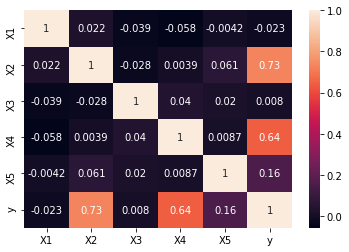

In [ ]:
sns.heatmap(df.corr(), annot=True);

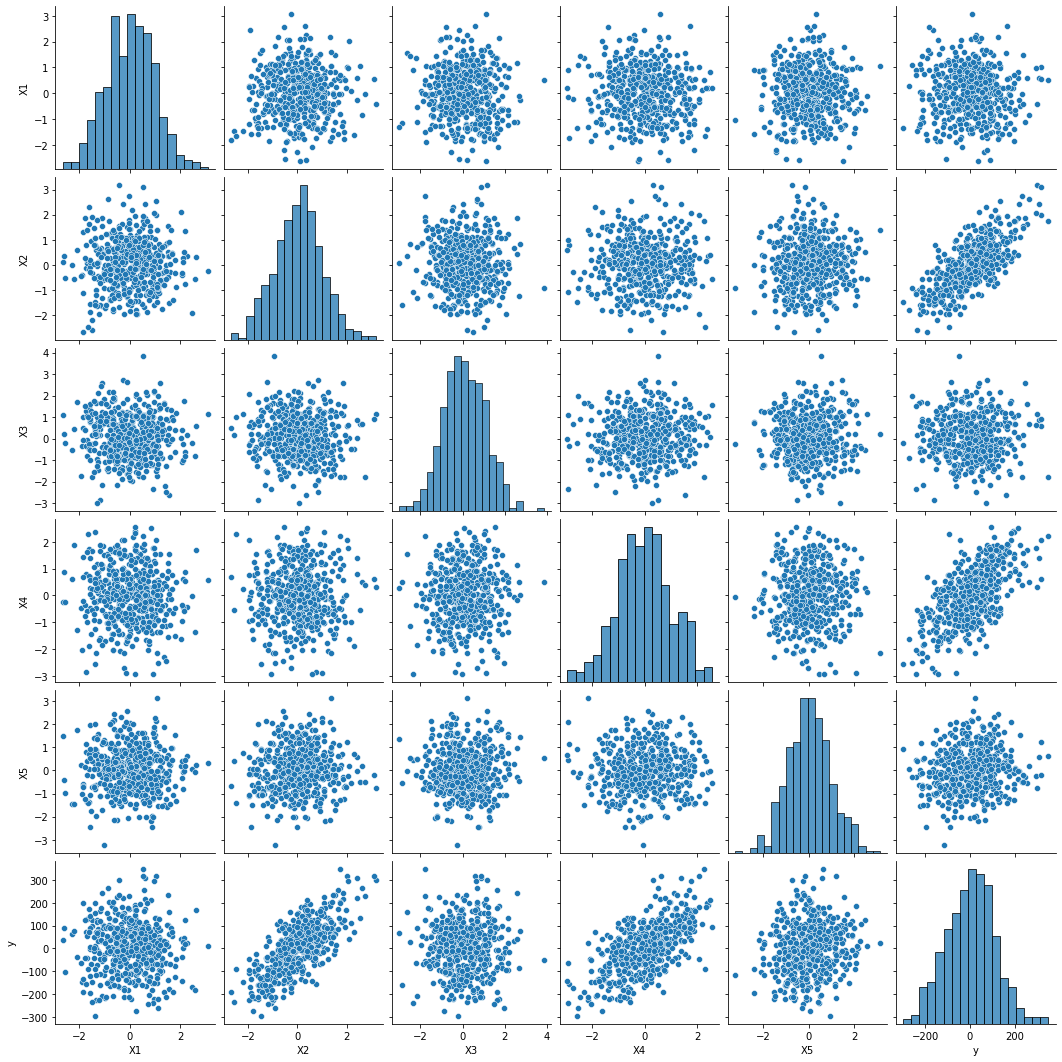

In [ ]:
sns.pairplot(df)

In [ ]:
df.describe()

,X1,X2,X3,X4,X5,y
count,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000
mean,0.012412,0.047211,0.089335,-0.004983,0.024845,3.420332
std,0.955087,0.969309,0.999397,1.038814,0.949985,110.693405
min,-2.650970,-2.703232,-3.019512,-2.940389,-3.241267,-297.665107
25%,-0.642849,-0.577418,-0.576895,-0.682826,-0.644153,-68.294863
50%,0.033078,0.081273,0.040829,-0.024875,0.008918,4.208483
75%,0.658720,0.668974,0.751524,0.671004,0.635892,76.120529
max,3.078881,3.193108,3.852731,2.558199,3.137749,349.448456


Os dados não têm variação de escala tão grande, então não nos preocuparemos em normaliza-los, caso queiramos utilizar regularização!

**Mas nunca se esqueça que isso é bastante importante quando há grandes diferenças de escala!!**


Agora, implementamos o CV:

In [ ]:
from sklearn.model_selection import KFold

In [ ]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

In [ ]:
vars(kf)

{'n_splits': 5, 'shuffle': True, 'random_state': 42}

In [ ]:
# qtos splists ha?

len(list(kf.split(X)))

5

In [ ]:
# em cada split, temos uma tupla ([indices de treino], [indices de validação])
# como visto acima, isso é feito pra cada split
# o que temos abaixo é apenas o primeiro split (indice 0)

list(kf.split(X))[0]

(array([  1,   3,   4,   5,   6,   7,   8,  10,  12,  13,  14,  16,  17,
         19,  20,  21,  23,  24,  25,  26,  27,  28,  29,  31,  32,  34,
         35,  36,  37,  38,  40,  41,  42,  43,  44,  45,  47,  48,  49,
         50,  51,  52,  53,  54,  56,  57,  58,  59,  60,  61,  62,  64,
         65,  66,  67,  71,  74,  80,  81,  83,  85,  87,  88,  89,  91,
         92,  94,  95,  96,  97,  98,  99, 100, 102, 103, 105, 106, 107,
        108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120,
        121, 122, 123, 125, 126, 127, 128, 129, 130, 132, 133, 134, 135,
        136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 149,
        150, 151, 152, 153, 156, 157, 158, 159, 160, 161, 162, 163, 164,
        165, 166, 167, 168, 169, 170, 171, 174, 175, 176, 177, 178, 179,
        181, 183, 184, 186, 187, 188, 189, 190, 191, 192, 195, 196, 197,
        198, 199, 200, 201, 202, 203, 205, 206, 207, 208, 210, 212, 213,
        214, 215, 216, 217, 218, 219, 220, 221, 222

In [ ]:
idcs_treino, idcs_val = list(kf.split(X))[0]

In [ ]:
idcs_val

array([  0,   2,   9,  11,  15,  18,  22,  30,  33,  39,  46,  55,  63,
        68,  69,  70,  72,  73,  75,  76,  77,  78,  79,  82,  84,  86,
        90,  93, 101, 104, 124, 131, 148, 154, 155, 172, 173, 180, 182,
       185, 193, 194, 204, 209, 211, 238, 262, 268, 277, 278, 280, 290,
       304, 312, 316, 317, 321, 323, 324, 333, 334, 336, 341, 347, 352,
       356, 361, 362, 371, 374, 377, 381, 384, 388, 391, 394, 406, 408,
       409, 410, 414, 415, 431, 438, 440, 450, 451, 455, 461, 465, 472,
       475, 477, 483, 485, 490, 491, 494, 495, 497])

In [ ]:
idcs_treino

array([  1,   3,   4,   5,   6,   7,   8,  10,  12,  13,  14,  16,  17,
        19,  20,  21,  23,  24,  25,  26,  27,  28,  29,  31,  32,  34,
        35,  36,  37,  38,  40,  41,  42,  43,  44,  45,  47,  48,  49,
        50,  51,  52,  53,  54,  56,  57,  58,  59,  60,  61,  62,  64,
        65,  66,  67,  71,  74,  80,  81,  83,  85,  87,  88,  89,  91,
        92,  94,  95,  96,  97,  98,  99, 100, 102, 103, 105, 106, 107,
       108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120,
       121, 122, 123, 125, 126, 127, 128, 129, 130, 132, 133, 134, 135,
       136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 149,
       150, 151, 152, 153, 156, 157, 158, 159, 160, 161, 162, 163, 164,
       165, 166, 167, 168, 169, 170, 171, 174, 175, 176, 177, 178, 179,
       181, 183, 184, 186, 187, 188, 189, 190, 191, 192, 195, 196, 197,
       198, 199, 200, 201, 202, 203, 205, 206, 207, 208, 210, 212, 213,
       214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 22

Como vimos acima, a classe KFold só gera os splits.

Mas, na prática, vamos usar o `cross_validate()`, que tem o KFold como argumento!!!

In [ ]:
from sklearn.model_selection import cross_validate

from sklearn.linear_model import ElasticNet

In [ ]:
en = ElasticNet()
kf5 = KFold(n_splits=5, shuffle=True, random_state=42)

result_cv = cross_validate(estimator=en, X=X, y=y, 
                           cv=kf5, scoring="neg_mean_absolute_error",
                           return_train_score=True)

In [ ]:
result_cv

{'fit_time': array([0.36151385, 0.00101948, 0.        , 0.00197816, 0.00099611]),
 'score_time': array([0.        , 0.        , 0.00101876, 0.        , 0.00100017]),
 'test_score': array([-37.24236843, -36.91545126, -33.87016282, -33.95473613,
        -33.5734684 ]),
 'train_score': array([-34.53892092, -34.92024842, -35.32918673, -35.49867268,
        -34.38269734])}

In [ ]:
df_result_cv = pd.DataFrame(result_cv)

df_result_cv = df_result_cv.abs()

# df_result_cv["test_score"] = df_result_cv["test_score"]*(-1)
# df_result_cv["train_score"] = df_result_cv["train_score"]*(-1)

Vamos olhar pros resultados mais de perto...

In [ ]:
df_result_cv

,fit_time,score_time,test_score,train_score
0,0.361514,0.000000,37.242368,34.538921
1,0.001019,0.000000,36.915451,34.920248
2,0.000000,0.001019,33.870163,35.329187
3,0.001978,0.000000,33.954736,35.498673
4,0.000996,0.001000,33.573468,34.382697


In [ ]:
df_result_cv[["train_score", "test_score"]].describe()

,train_score,test_score
count,5.000000,5.000000
mean,34.933945,35.111237
std,0.483539,1.805506
min,34.382697,33.573468
25%,34.538921,33.870163
50%,34.920248,33.954736
75%,35.329187,36.915451
max,35.498673,37.242368


<AxesSubplot:xlabel='train_score', ylabel='Count'>

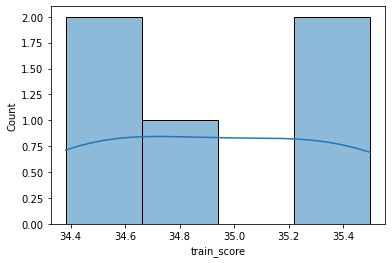

In [ ]:
sns.histplot(data=df_result_cv, x="train_score", kde=True)

<AxesSubplot:xlabel='test_score', ylabel='Count'>

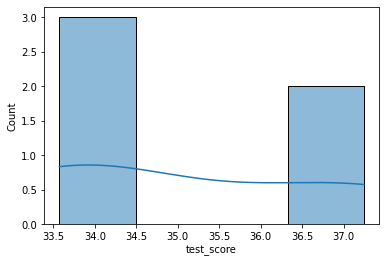

In [ ]:
sns.histplot(data=df_result_cv, x="test_score", kde=True)

Numa unica celula:


In [ ]:
def plot_cv(estimator, X, y, n_splits, scoring):
    '''
    scoring: string relativa às métricas
    '''
    
    kf5 = KFold(n_splits=n_splits, shuffle=True, random_state=42)

    result_cv = cross_validate(estimator=estimator, X=X, y=y, 
                               cv=kf5, scoring=scoring,
                               return_train_score=True)
    
    # ============================

    df_result_cv = pd.DataFrame(result_cv)
    df_result_cv = df_result_cv.abs()
    
    display(df_result_cv[["train_score", "test_score"]].describe())
    
    # ============================
    
    print("\nDistribuição de métricas de treino:")
    sns.histplot(data=df_result_cv, x="train_score", kde=True)
    plt.show()
    
    print("\nDistribuição de métricas de teste:")
    sns.histplot(data=df_result_cv, x="test_score", kde=True)
    plt.show()
    
    print("\nAs duas juntas (compare a variância!):")
    sns.histplot(data=df_result_cv, x="train_score", kde=True)
    sns.histplot(data=df_result_cv, x="test_score", color="orange", kde=True)
    plt.show()

,train_score,test_score
count,30.000000,30.000000
mean,34.913566,35.118937
std,0.144129,7.124084
min,34.683546,21.635696
25%,34.816336,30.535681
50%,34.885635,35.276464
75%,35.006462,39.876677
max,35.198265,47.729019



Distribuição de métricas de treino:


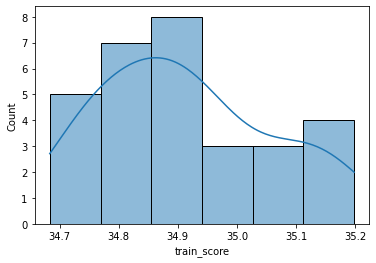


Distribuição de métricas de teste:


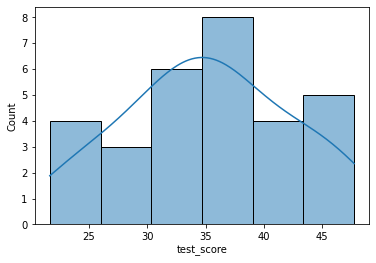


As duas juntas (compare a variância!):


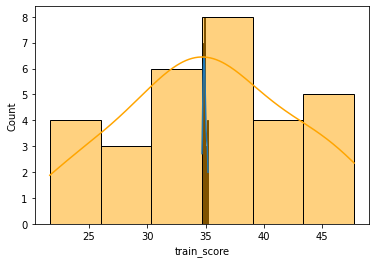

In [ ]:
en = ElasticNet()

plot_cv(en, X, y, n_splits=30, scoring="neg_mean_absolute_error")

Comparando com o train-test split direto

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# ================================

en = ElasticNet().fit(X_train, y_train)

# ================================

from sklearn.metrics import mean_absolute_error

y_pred_train = en.predict(X_train)
print("\nMétrica de treino:")
print(mean_absolute_error(y_train, y_pred_train))

y_pred_test = en.predict(X_test)
print("\nMétrica de teste:")
print(mean_absolute_error(y_test, y_pred_test))


Métrica de treino:
34.52420837921775

Métrica de teste:
39.05591800744537


**Na prática, para bases maiores, nós fazemos realmente como está na figura lá em cima**

Isto é:

- primeiro fazemos o train-test split;
- aí, aplicamos CV na base de treino;
- depois testamos na base de teste

Isso é sobretudo importante no segundo "uso" do cv, que é otimização de hiperparametros

______
_____
____

Caso queira usar mais métricas de uma vez... SEM PROBLEMAS :)

In [ ]:
n_splits = 5
estimator = ElasticNet()
scoring=("neg_mean_absolute_error", "neg_root_mean_squared_error", "r2")

kf5 = KFold(n_splits=n_splits, shuffle=True, random_state=42)

result_cv = cross_validate(estimator=estimator, X=X, y=y, 
                           cv=kf5, scoring=scoring,
                           return_train_score=True)

# ============================

df_result_cv = pd.DataFrame(result_cv)
df_result_cv = df_result_cv.abs()

df_result_cv

,fit_time,score_time,test_neg_mean_absolute_error,train_neg_mean_absolute_error,test_neg_root_mean_squared_error,train_neg_root_mean_squared_error,test_r2,train_r2
0,0.002997,0.000999,37.242368,34.538921,45.674374,43.276767,0.829117,0.846058
1,0.000999,0.001008,36.915451,34.920248,46.934037,43.285737,0.830471,0.844345
2,0.000998,0.001004,33.870163,35.329187,42.583387,44.036324,0.858233,0.839472
3,0.001000,0.001002,33.954736,35.498673,43.581829,43.966468,0.845657,0.839496
4,0.001002,0.000992,33.573468,34.382697,40.419302,43.217668,0.837599,0.853698


,train_neg_mean_absolute_error,test_neg_mean_absolute_error
count,5.000000,5.000000
mean,34.933945,35.111237
std,0.483539,1.805506
min,34.382697,33.573468
25%,34.538921,33.870163
50%,34.920248,33.954736
75%,35.329187,36.915451
max,35.498673,37.242368



Distribuição da métrica neg_mean_absolute_error de treino:


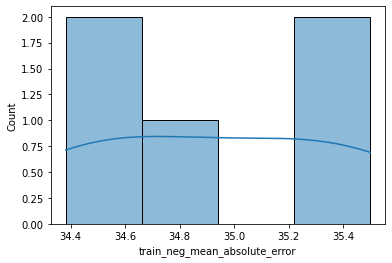


Distribuição da métrica neg_mean_absolute_error de teste:


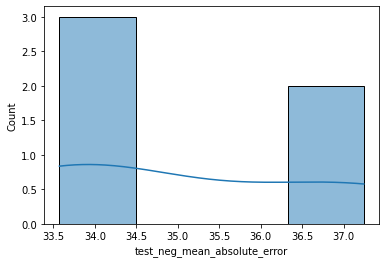

################################################################################


,train_neg_root_mean_squared_error,test_neg_root_mean_squared_error
count,5.000000,5.000000
mean,43.556593,43.838586
std,0.407638,2.563440
min,43.217668,40.419302
25%,43.276767,42.583387
50%,43.285737,43.581829
75%,43.966468,45.674374
max,44.036324,46.934037



Distribuição da métrica neg_root_mean_squared_error de treino:


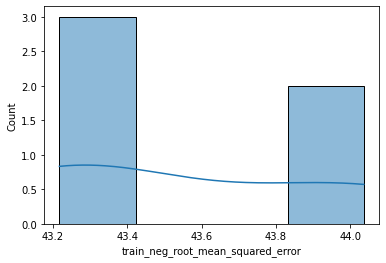


Distribuição da métrica neg_root_mean_squared_error de teste:


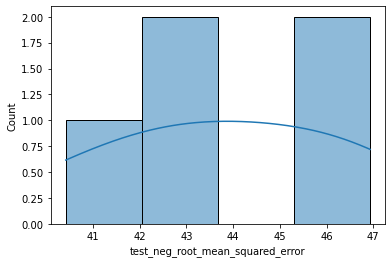

################################################################################


,train_r2,test_r2
count,5.000000,5.000000
mean,0.844614,0.840215
std,0.005859,0.012034
min,0.839472,0.829117
25%,0.839496,0.830471
50%,0.844345,0.837599
75%,0.846058,0.845657
max,0.853698,0.858233



Distribuição da métrica r2 de treino:


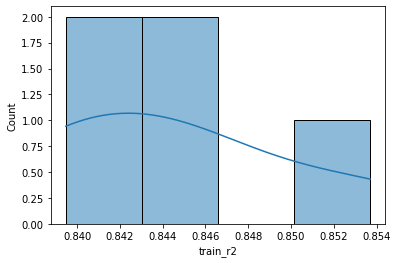


Distribuição da métrica r2 de teste:


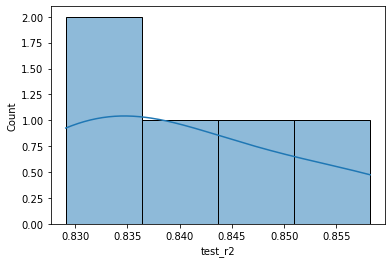

################################################################################


In [ ]:
colunas_metricas = df_result_cv.columns.tolist()[2:]

for i in range(0, len(colunas_metricas), 2):
    
    display(df_result_cv[[colunas_metricas[i+1], colunas_metricas[i]]].describe())
    
    print(f'\nDistribuição da métrica {colunas_metricas[i+1].replace("train_", "")} de treino:')
    sns.histplot(data=df_result_cv, x=colunas_metricas[i+1], kde=True)
    plt.show()
    
    print(f'\nDistribuição da métrica {colunas_metricas[i].replace("test_", "")} de teste:')
    sns.histplot(data=df_result_cv, x=colunas_metricas[i], kde=True)
    plt.show()

    print("#"*80)

_______________

In [ ]:
def plot_cv_varias_metricas(estimator, X, y, n_splits, scoring):
    '''
    scoring: tupla de strings relativas às métricas
    '''
    
    kf5 = KFold(n_splits=n_splits, shuffle=True, random_state=42)

    result_cv = cross_validate(estimator=estimator, X=X, y=y, 
                               cv=kf5, scoring=scoring,
                               return_train_score=True)
    
    # ============================

    df_result_cv = pd.DataFrame(result_cv)
    df_result_cv = df_result_cv.abs()
    
    colunas_metricas = df_result_cv.columns.tolist()[2:]

    for i in range(0, len(colunas_metricas), 2):

        display(df_result_cv[[colunas_metricas[i+1], colunas_metricas[i]]].describe())

        print(f'\nDistribuição da métrica {colunas_metricas[i+1].replace("train_", "")} de treino:')
        sns.histplot(data=df_result_cv, x=colunas_metricas[i+1], kde=True)
        plt.show()

        print(f'\nDistribuição da métrica {colunas_metricas[i].replace("test_", "")} de teste:')
        sns.histplot(data=df_result_cv, x=colunas_metricas[i], kde=True)
        plt.show()

        print("\nAs duas juntas (compare a variância!):")
        sns.histplot(data=df_result_cv, x=colunas_metricas[i+1], label="treino", kde=True)
        sns.histplot(data=df_result_cv, x=colunas_metricas[i], color="orange", label="teste", kde=True)
        plt.legend()
        plt.show()
        
        print("#"*80)
    

,train_neg_mean_absolute_error,test_neg_mean_absolute_error
count,30.000000,30.000000
mean,34.913566,35.118937
std,0.144129,7.124084
min,34.683546,21.635696
25%,34.816336,30.535681
50%,34.885635,35.276464
75%,35.006462,39.876677
max,35.198265,47.729019



Distribuição da métrica neg_mean_absolute_error de treino:


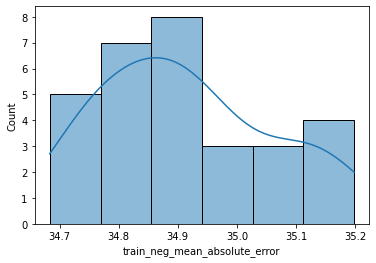


Distribuição da métrica neg_mean_absolute_error de teste:


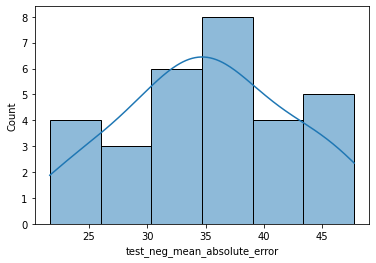


As duas juntas (compare a variância!):


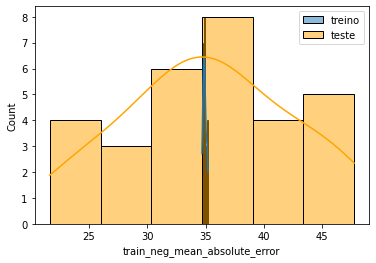

################################################################################


,train_neg_root_mean_squared_error,test_neg_root_mean_squared_error
count,30.000000,30.000000
mean,43.561148,43.161349
std,0.134884,7.876156
min,43.302666,27.779693
25%,43.473587,38.337612
50%,43.543192,42.605086
75%,43.634248,48.166132
max,43.839619,60.211813



Distribuição da métrica neg_root_mean_squared_error de treino:


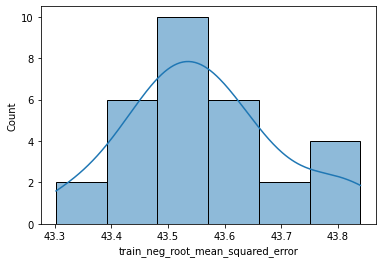


Distribuição da métrica neg_root_mean_squared_error de teste:


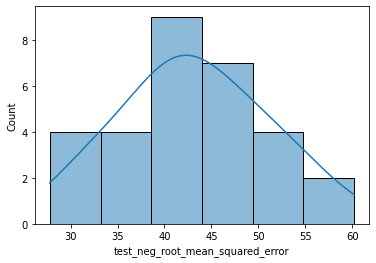


As duas juntas (compare a variância!):


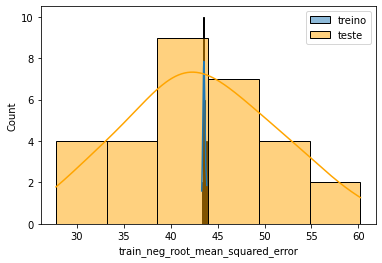

################################################################################


,train_r2,test_r2
count,30.000000,30.000000
mean,0.844783,0.828963
std,0.002616,0.036106
min,0.839848,0.749952
25%,0.842733,0.812329
50%,0.845213,0.826827
75%,0.846661,0.853945
max,0.849561,0.892042



Distribuição da métrica r2 de treino:


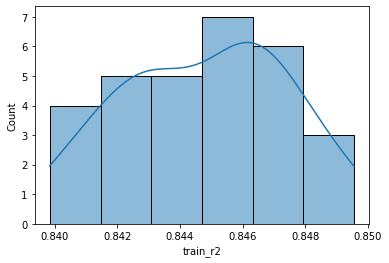


Distribuição da métrica r2 de teste:


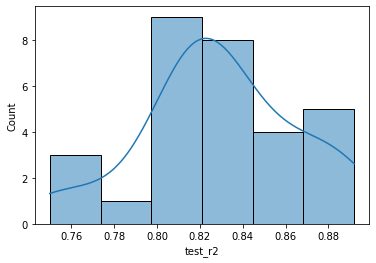


As duas juntas (compare a variância!):


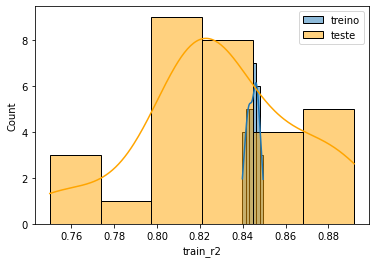

################################################################################


In [ ]:
en = ElasticNet()
scoring=("neg_mean_absolute_error", "neg_root_mean_squared_error", "r2")

plot_cv_varias_metricas(en, X, y, n_splits=30, scoring=scoring)

_____

Vamos agora ver um caso de **classificação**:

In [ ]:
from sklearn.datasets import make_classification

X_clf, y_clf = make_classification(n_samples=500,
                                 n_features=5, n_informative=3,
                                 n_classes=2,
                                 random_state=42)

X_clf_df = pd.DataFrame(X_clf, columns=[f'X{i+1}' for i in range(X_clf.shape[1])]) 
y_clf_df = pd.Series(y_clf, name="y")
                        
df_clf = pd.concat([X_clf_df, y_clf_df], axis=1)

df_clf

,X1,X2,X3,X4,X5,y
0,0.280056,-1.126421,-0.772964,2.060626,-2.357044,0
1,-0.326002,0.343967,1.535987,-1.794578,1.293605,1
2,-0.802972,-1.112616,-1.088524,0.668720,-1.183952,0
3,0.012285,-0.350602,-1.359103,1.234112,-0.909008,0
4,0.043145,-1.077267,-0.873334,1.727960,-2.031498,0
...,...,...,...,...,...,...
495,-0.487169,-0.351560,0.458356,-0.631618,0.076135,0
496,-0.114580,-1.433468,-0.513094,1.641968,-2.358049,0
497,-1.292011,-0.504030,0.758286,-1.832484,0.803280,1
498,0.287141,1.553864,0.125348,-1.272565,2.271871,1


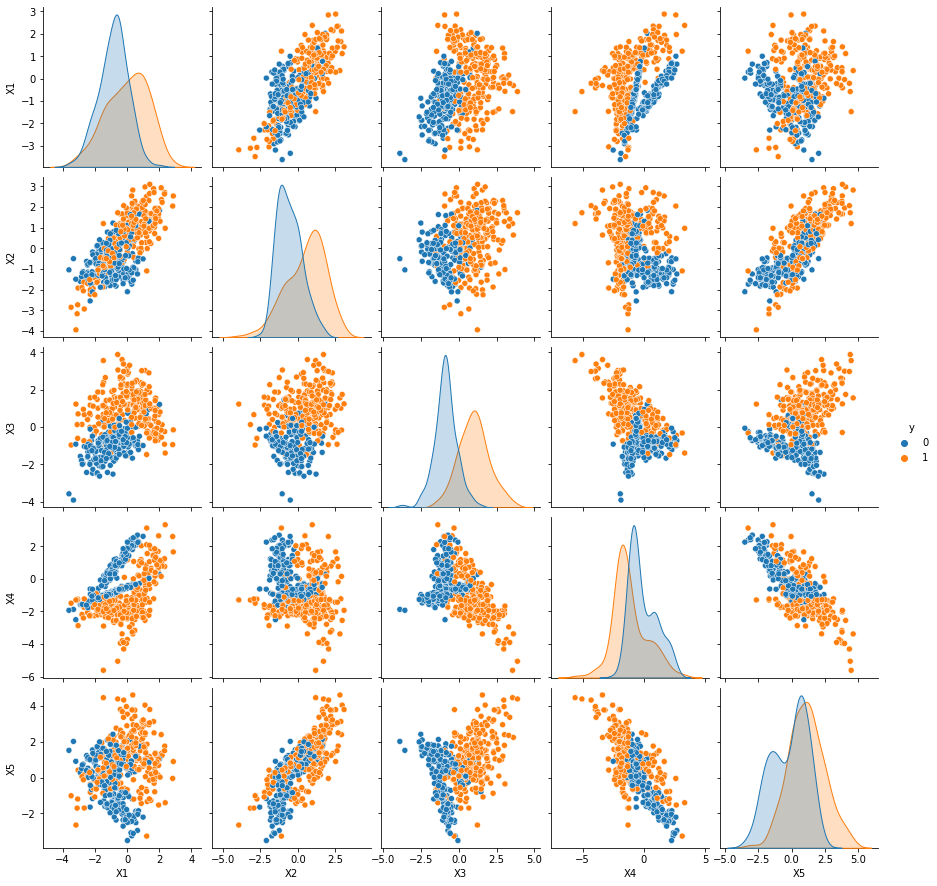

In [ ]:
sns.pairplot(df_clf, hue="y")

Agora, o CV, bem parecido com o que fizemos acima:

- uma regressão logística com regularização l1 e fator de regularização (C) igual a 1.2;
- 10 folds;
- roc_auc como métrica de avaliação.

In [ ]:
from sklearn.linear_model import LogisticRegression

,train_score,test_score
count,10.000000,10.000000
mean,0.942945,0.940544
std,0.002497,0.023745
min,0.940402,0.893268
25%,0.941518,0.935897
50%,0.942010,0.951190
75%,0.943019,0.953301
max,0.948221,0.967159



Distribuição de métricas de treino:


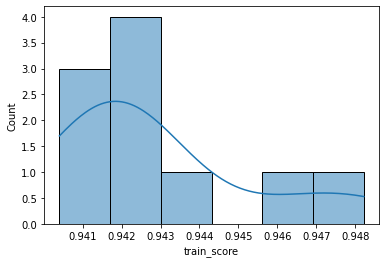


Distribuição de métricas de teste:


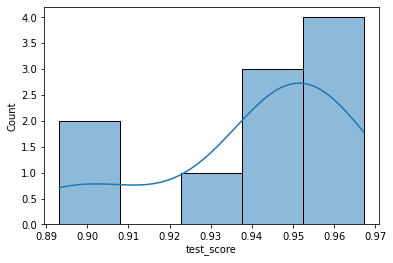


As duas juntas (compare a variância!):


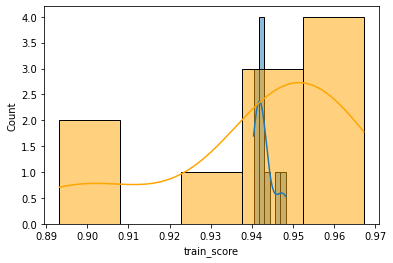

In [ ]:
lr = LogisticRegression(penalty="l1", C=1.2, solver="liblinear")

plot_cv(lr, X_clf, y_clf, n_splits=10, scoring="roc_auc")

,train_roc_auc,test_roc_auc
count,10.000000,10.000000
mean,0.942939,0.940544
std,0.002503,0.023745
min,0.940382,0.893268
25%,0.941483,0.935897
50%,0.942010,0.951190
75%,0.943034,0.953301
max,0.948221,0.967159



Distribuição da métrica roc_auc de treino:


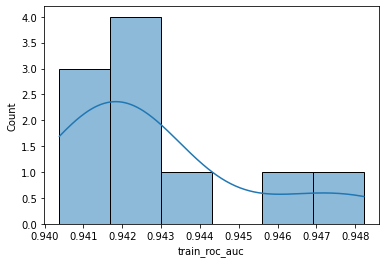


Distribuição da métrica roc_auc de teste:


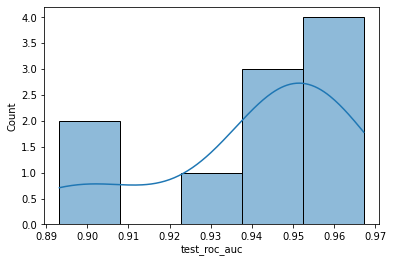


As duas juntas (compare a variância!):


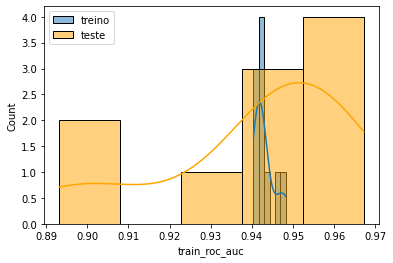

################################################################################


,train_f1,test_f1
count,10.000000,10.000000
mean,0.885291,0.880805
std,0.003825,0.050534
min,0.879650,0.800000
25%,0.881904,0.859838
50%,0.885964,0.874960
75%,0.888141,0.920000
max,0.890323,0.947368



Distribuição da métrica f1 de treino:


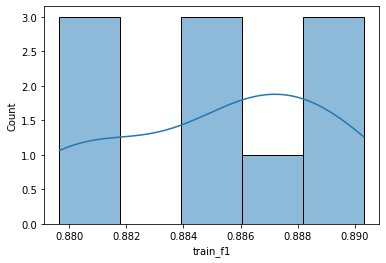


Distribuição da métrica f1 de teste:


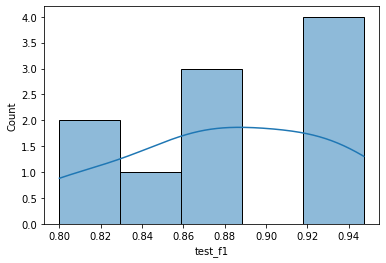


As duas juntas (compare a variância!):


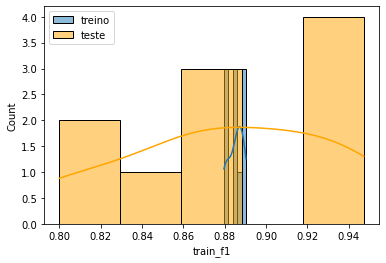

################################################################################


In [ ]:
lr = LogisticRegression(penalty="l1", C=1.2, solver="liblinear")

plot_cv_varias_metricas(lr, X_clf, y_clf, n_splits=10, scoring=("roc_auc", "f1"))

____________

## 2) Ajuste de hiperparâmetros

Além de permitir uma avaliação mais robusta de um modelo, o CV pode também ser utilizado para um propósito muito importante: **a escolha de valores adequados de hiperparâmetros** de um modelo -- processo conhecido como **hyperparameter tuning**.

<img src=https://www.okw.com/en/Com-Knobs/COM-KNOBS-class-OKW_GroupInfoImage500x408.jpg width=400>

Na aula que vem vamos estudar uma forma mais estruturada de fazer este procedimento.

Mas, nesta aula, vamos ver formas automáticas e diretas de aplicar CV aos modelos que conhecemos!

Antes de irmos pra prática, uma pergunta importante é: **como/por que utilizar CV para o ajuste de hiperparâmetros?**

Ao testarmos diferentes valores/combinações de hiperparâmetros em diferentes folds, temos uma estimativa mais realista sobre o efeito destas escolhas: se o resultado for bom em todos os folds (ou bom em média), temos um indicativo mais robusto de que de fato aquela é uma boa escolha. Em particular, fica muito mais difícil de cometermos **overfitting** através da escolha de hiperparâmetros que ajustem muito bem uma única base de treino. Faz sentido, né?

Para saber mais sobre estas questões, sugiro [este post](https://towardsdatascience.com/cross-validation-and-hyperparameter-tuning-how-to-optimise-your-machine-learning-model-13f005af9d7d) e [este post](https://machinelearningmastery.com/nested-cross-validation-for-machine-learning-with-python/).

No sklearn, temos o procedimento de CV incorporado a algumas classes de hipóteses:

- [Lasso CV](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LassoCV.html)
- [Ridge CV](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeCV.html)
- [ElasticNetCV](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNetCV.html)
- [LogisticRegressionCV](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegressionCV.html)

Em todos os casos, é possível especificar uma lista de hiperparâmetros a serem percorridos, e o modelo com melhor hiperparâmetro (ou combinação de hiperparâmetros) é escolhido! 

Vamos pegar as bases acima e aplicar os métodos de CV built-in pra ver se encontramos resultados melhores:

In [ ]:
np.linspace(0.1, 1, 100)

array([0.1       , 0.10909091, 0.11818182, 0.12727273, 0.13636364,
       0.14545455, 0.15454545, 0.16363636, 0.17272727, 0.18181818,
       0.19090909, 0.2       , 0.20909091, 0.21818182, 0.22727273,
       0.23636364, 0.24545455, 0.25454545, 0.26363636, 0.27272727,
       0.28181818, 0.29090909, 0.3       , 0.30909091, 0.31818182,
       0.32727273, 0.33636364, 0.34545455, 0.35454545, 0.36363636,
       0.37272727, 0.38181818, 0.39090909, 0.4       , 0.40909091,
       0.41818182, 0.42727273, 0.43636364, 0.44545455, 0.45454545,
       0.46363636, 0.47272727, 0.48181818, 0.49090909, 0.5       ,
       0.50909091, 0.51818182, 0.52727273, 0.53636364, 0.54545455,
       0.55454545, 0.56363636, 0.57272727, 0.58181818, 0.59090909,
       0.6       , 0.60909091, 0.61818182, 0.62727273, 0.63636364,
       0.64545455, 0.65454545, 0.66363636, 0.67272727, 0.68181818,
       0.69090909, 0.7       , 0.70909091, 0.71818182, 0.72727273,
       0.73636364, 0.74545455, 0.75454545, 0.76363636, 0.77272

In [ ]:
from sklearn.linear_model import LassoCV

kf5 = KFold(n_splits=10, shuffle=True, random_state=42)

l1 = LassoCV(alphas=np.linspace(0.1, 1, 100), cv=kf5, verbose=50).fit(X, y)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
(array([-0.        , 81.26206618, -0.        , 66.71317838, 10.99012932]), 0.7174938791431487, 556.4634617202245, 4)
(array([-0.        , 81.27078268, -0.        , 66.7214594 , 10.99968657]), 0.6228538766736165, 556.4634617202245, 2)
(array([-0.        , 81.27950165, -0.        , 66.72974008, 11.00924357]), 0.6229109197156504, 556.4634617202245, 2)
(array([-0.        , 81.28822062, -0.        , 66.73802076, 11.01880057]), 0.6229856673744507, 556.4634617202245, 2)
(array([-0.        , 81.29693959, -0.        , 66.74630145, 11.02835757]), 0.6230604145093821, 556.4634617202245, 2)
(array([-0.        , 81.30565856, -0.        , 66.75458213, 11.03791457]), 0.6231351675232872, 556.4634617202245, 2)
(array([-0.        , 81.31437753, -0.        , 66.76286281, 11.04747157]), 0.6232099161716178, 556.4634617202245, 2)
(array([-0.        , 81.3230965 , -0.        , 66.77114349, 11.05702856]), 0.6232846700004302, 556.4

(array([-0.        , 81.53239118,  0.        , 67.25972852, 11.88431951]), 0.12377896319958381, 541.8045156519711, 2)
(array([-0.        , 81.54184176,  0.        , 67.26796151, 11.89370532]), 0.1237934771925211, 541.8045156519711, 2)
(array([-0.        , 81.55129234,  0.        , 67.2761945 , 11.90309113]), 0.12380799558013678, 541.8045156519711, 2)
(array([-0.        , 81.56074292,  0.        , 67.2844275 , 11.91247694]), 0.12382250837981701, 541.8045156519711, 2)
(array([-0.        , 81.57019351,  0.        , 67.29266049, 11.92186275]), 0.12383702490478754, 541.8045156519711, 2)
(array([-0.        , 81.57964409,  0.        , 67.30089348, 11.93124856]), 0.12385154142975807, 541.8045156519711, 2)
(array([-0.        , 81.58909467,  0.        , 67.30912648, 11.94063437]), 0.12386605702340603, 541.8045156519711, 2)
(array([-0.        , 81.59854525,  0.        , 67.31735947, 11.95002018]), 0.12388057351927273, 541.8045156519711, 2)
(array([-0.        , 81.60799583,  0.        , 67.3255924

(array([ 0.        , 81.13650059,  0.        , 66.71545732, 11.64878116]), 0.12879507610341534, 536.8745359451503, 2)
(array([ 0.        , 81.14574094,  0.        , 66.72369677, 11.65821941]), 0.12880993989529088, 536.8745359451503, 2)
(array([ 0.        , 81.15498129,  0.        , 66.73193622, 11.66765767]), 0.12882480467669666, 536.8745359451503, 2)
(array([ 0.        , 81.16422163,  0.        , 66.74017567, 11.67709592]), 0.12883967033121735, 536.8745359451503, 2)
(array([ 0.        , 81.17346198,  0.        , 66.74841513, 11.68653417]), 0.12885453511262313, 536.8745359451503, 2)
(array([ 0.        , 81.18270233,  0.        , 66.75665458, 11.69597242]), 0.12886939849704504, 536.8745359451503, 2)
(array([ 0.        , 81.19194267,  0.        , 66.76489403, 11.70541067]), 0.1288842624053359, 536.8745359451503, 2)
(array([ 0.        , 81.20118302,  0.        , 66.77313348, 11.71484893]), 0.12889912741957232, 536.8745359451503, 2)
(array([ 0.        , 81.21042337,  0.        , 66.7813729

(array([-0.        , 81.83784981, -0.        , 67.40485065, 11.39256014]), 0.0993237312650308, 546.3967195634413, 2)
(array([-0.        , 81.84698919, -0.        , 67.4134419 , 11.40190499]), 0.09933641878888011, 546.3967195634413, 2)
(array([-0.        , 81.85612857, -0.        , 67.42203314, 11.41124985]), 0.09934910503216088, 546.3967195634413, 2)
(array([-0.        , 81.86526796, -0.        , 67.43062439, 11.4205947 ]), 0.09936178987845778, 546.3967195634413, 2)
(array([-0.        , 81.87440734, -0.        , 67.43921564, 11.42993955]), 0.09937447891570628, 546.3967195634413, 2)
(array([-0.        , 81.88354672, -0.        , 67.44780689, 11.43928441]), 0.09938716399483383, 546.3967195634413, 2)
(array([-0.        , 81.8926861 , -0.        , 67.45639813, 11.44862926]), 0.09939985175151378, 546.3967195634413, 2)
(array([-0.        , 81.90182548, -0.        , 67.46498938, 11.45797411]), 0.0994125361321494, 546.3967195634413, 2)
(array([-0.        , 81.91096486, -0.        , 67.47358063

(array([-0.        , 81.97671807, -0.        , 67.43737605, 12.12327885]), 0.05951811088016257, 548.2674224191173, 2)
(array([-0.        , 81.98585044, -0.        , 67.44586756, 12.13240066]), 0.05952488613547757, 548.2674224191173, 2)
(array([-0.        , 81.99498282, -0.        , 67.45435906, 12.14152247]), 0.05953166144900024, 548.2674224191173, 2)
(array([-0.        , 82.0041152 , -0.        , 67.46285056, 12.15064428]), 0.05953843891620636, 548.2674224191173, 2)
(array([-0.        , 82.01324757, -0.        , 67.47134207, 12.15976609]), 0.059545214811805636, 548.2674224191173, 2)
(array([-0.        , 82.02237995, -0.        , 67.47983357, 12.1688879 ]), 0.05955199059098959, 548.2674224191173, 2)
(array([-0.        , 82.03151233, -0.        , 67.48832507, 12.1780097 ]), 0.05955876410007477, 548.2674224191173, 2)
(array([-0.        , 82.0406447 , -0.        , 67.49681658, 12.18713151]), 0.059565541334450245, 548.2674224191173, 2)
(array([-0.        , 82.04977708, -0.        , 67.5053

(array([-0.        , 81.85087226,  0.        , 67.60084615, 11.67464731]), 0.17110117431730032, 521.170000857463, 2)
(array([-0.        , 81.86056405,  0.        , 67.60960089, 11.68379792]), 0.1711216353578493, 521.170000857463, 2)
(array([-0.        , 81.87025584,  0.        , 67.61835563, 11.69294853]), 0.17114209276041947, 521.170000857463, 2)
(array([-0.        , 81.87994762,  0.        , 67.62711037, 11.70209914]), 0.17116255313158035, 521.170000857463, 2)
(array([-0.        , 81.88963941,  0.        , 67.63586511, 11.71124975]), 0.17118301300797611, 521.170000857463, 2)
(array([-0.        , 81.8993312 ,  0.        , 67.64461985, 11.72040036]), 0.1712034738739021, 521.170000857463, 2)
(array([-0.        , 81.90902298,  0.        , 67.65337458, 11.72955097]), 0.171223932353314, 521.170000857463, 2)
(array([-0.        , 81.91871477,  0.        , 67.66212932, 11.73870158]), 0.17124439403414726, 521.170000857463, 2)
(array([-0.        , 81.92840656,  0.        , 67.67088406, 11.74785

(array([ 0.        , 81.78974661,  0.        , 67.84749507, 11.54060095]), 0.06691695936024189, 572.5946116755196, 2)
(array([ 0.        , 81.79849399,  0.        , 67.85555795, 11.54993999]), 0.06692442391067743, 572.5946116755196, 2)
(array([ 0.        , 81.80724137,  0.        , 67.86362084, 11.55927903]), 0.06693188566714525, 572.5946116755196, 2)
(array([ 0.        , 81.81598874,  0.        , 67.87168372, 11.56861808]), 0.06693934742361307, 572.5946116755196, 2)
(array([ 0.        , 81.82473612,  0.        , 67.8797466 , 11.57795712]), 0.06694681372027844, 572.5946116755196, 2)
(array([ 0.        , 81.8334835 ,  0.        , 67.88780949, 11.58729617]), 0.06695427827071398, 572.5946116755196, 2)
(array([ 0.        , 81.84223087,  0.        , 67.89587237, 11.59663521]), 0.06696174200624228, 572.5946116755196, 2)
(array([ 0.        , 81.85097825,  0.        , 67.90393525, 11.60597425]), 0.06696920626563951, 572.5946116755196, 2)
(array([ 0.        , 81.85972563,  0.        , 67.911998

(array([ 0.        , 81.57468498, -0.        , 66.98301827, 11.66662641]), 0.00775277114007622, 572.678534456256, 4)
(array([ 0.        , 81.58334212, -0.        , 66.99103809, 11.67611619]), 0.04085553655750118, 572.678534456256, 2)
(array([ 0.        , 81.5919986 , -0.        , 66.99905731, 11.68560603]), 0.04085837662569247, 572.678534456256, 2)
(array([ 0.        , 81.60065507, -0.        , 67.00707652, 11.69509587]), 0.040863016445655376, 572.678534456256, 2)
(array([ 0.        , 81.60931155, -0.        , 67.01509574, 11.7045857 ]), 0.04086765999090858, 572.678534456256, 2)
(array([ 0.        , 81.61796803, -0.        , 67.02311495, 11.71407554]), 0.040872298181056976, 572.678534456256, 2)
(array([ 0.        , 81.62662451, -0.        , 67.03113417, 11.72356538]), 0.040876940824091434, 572.678534456256, 2)
(array([ 0.        , 81.63528098, -0.        , 67.03915338, 11.73305522]), 0.04088158439844847, 572.678534456256, 2)
(array([ 0.        , 81.64393746, -0.        , 67.0471726 , 1

        1.25315375e+01]), 0.33063173992559314, 572.678534456256, 2)
(array([ 0.0873969 , 82.36993152, -0.        , 67.72638032, 12.54121177]), 0.33068489911966026, 572.678534456256, 2)
(array([ 0.098     , 82.37844828, -0.        , 67.73507814, 12.55088607]), 0.33073885820340365, 572.678534456256, 2)
(array([ 0.1086031 , 82.38696504, -0.        , 67.74377597, 12.56056037]), 0.33079384005395696, 572.678534456256, 2)
(array([ 0.11920619, 82.3954818 , -0.        , 67.7524738 , 12.57023467]), 0.330850122962147, 572.678534456256, 2)
(array([ 0.12980929, 82.40399856, -0.        , 67.76117162, 12.57990897]), 0.3309080969193019, 572.678534456256, 2)
(array([ 0.14041239, 82.41251532, -0.        , 67.76986945, 12.58958327]), 0.3309683126572054, 572.678534456256, 2)
(array([ 0.15101548, 82.42103208, -0.        , 67.77856727, 12.59925757]), 0.3310315436683595, 572.678534456256, 2)
(array([ 0.16161858, 82.42954884, -0.        , 67.7872651 , 12.60893186]), 0.33109895829693414, 572.678534456256, 2)
[

In [ ]:
l1

LassoCV(alphas=array([0.1       , 0.10909091, 0.11818182, 0.12727273, 0.13636364,
       0.14545455, 0.15454545, 0.16363636, 0.17272727, 0.18181818,
       0.19090909, 0.2       , 0.20909091, 0.21818182, 0.22727273,
       0.23636364, 0.24545455, 0.25454545, 0.26363636, 0.27272727,
       0.28181818, 0.29090909, 0.3       , 0.30909091, 0.31818182,
       0.32727273, 0.33636364, 0.34545455, 0.35454545, 0.36363636,
       0.37272727, 0.381818...
       0.73636364, 0.74545455, 0.75454545, 0.76363636, 0.77272727,
       0.78181818, 0.79090909, 0.8       , 0.80909091, 0.81818182,
       0.82727273, 0.83636364, 0.84545455, 0.85454545, 0.86363636,
       0.87272727, 0.88181818, 0.89090909, 0.9       , 0.90909091,
       0.91818182, 0.92727273, 0.93636364, 0.94545455, 0.95454545,
       0.96363636, 0.97272727, 0.98181818, 0.99090909, 1.        ]),
        cv=KFold(n_splits=10, random_state=42, shuffle=True), verbose=50)

In [ ]:
l1.alpha_

0.4545454545454546

In [ ]:
from sklearn.linear_model import ElasticNetCV

kf5 = KFold(n_splits=10, shuffle=True, random_state=42)

en = ElasticNetCV(alphas=np.linspace(0.5, 1, 20), l1_ratio=np.linspace(0.1, 1, 20),
                  cv=kf5, verbose=50).fit(X, y)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
(array([-6.28259509e-01,  4.22041148e+01, -2.99203665e-03,  3.74746584e+01,
        7.57988362e+00]), 0.07002397277392447, 556.4634617202245, 4)
(array([-6.31421067e-01,  4.27510683e+01, -5.20206623e-03,  3.79205084e+01,
        7.66065253e+00]), 0.06395944487303495, 556.4634617202245, 3)
(array([-6.34520871e-01,  4.33123848e+01, -7.45702811e-03,  3.83770478e+01,
        7.74300924e+00]), 0.07679845741949975, 556.4634617202245, 3)
(array([-6.37551092e-01,  4.38886392e+01, -9.75708792e-03,  3.88446649e+01,
        7.82699423e+00]), 0.09087577741593122, 556.4634617202245, 3)
(array([-6.40503605e-01,  4.44804375e+01, -1.21021068e-02,  3.93237672e+01,
        7.91264880e+00]), 0.1041263488586992, 556.4634617202245, 3)
(array([-6.43369496e-01,  4.50884192e+01, -1.44917648e-02,  3.98147821e+01,
        8.00001505e+00]), 0.11239876481704414, 556.4634617202245, 3)
(array([-6.46139746e-01,  4.57132594e+01, -1.69254

(array([-0.38229224, 45.63295124,  0.5626319 , 39.42972272,  7.43807689]), 0.030758578330278397, 556.0399062425257, 3)
(array([-0.38279666, 46.26187801,  0.56318278, 39.93795414,  7.53092353]), 0.033199138240888715, 556.0399062425257, 3)
(array([-0.3831652 , 46.90834771,  0.56354187, 40.45942594,  7.62603348]), 0.03586985031142831, 556.0399062425257, 3)
(array([-0.38338679, 47.57310511,  0.56369371, 40.99466252,  7.72348802]), 0.038795959670096636, 556.0399062425257, 3)
(array([-0.38344944, 48.25693778,  0.56362161, 41.54421638,  7.82337213]), 0.042005880270153284, 556.0399062425257, 3)
(array([-0.38334023, 48.96067919,  0.56330753, 42.10866997,  7.9257748 ]), 0.04553164937533438, 556.0399062425257, 3)
(array([-0.38304514, 49.6852121 ,  0.56273199, 42.6886378 ,  8.03078917]), 0.04940944095142186, 556.0399062425257, 3)
(array([-0.38254906, 50.43147231,  0.56187393, 43.28476861,  8.13851276]), 0.05368018080480397, 556.0399062425257, 3)
(array([-0.3818356 , 51.20045265,  0.56071053, 43.89

        9.49410258e+00]), 0.09513883665204048, 572.5946116755196, 3)
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.2s remaining:    0.0s
(array([-1.13047622, 42.18317067,  0.11320793, 37.11434192,  6.94232898]), 0.02094322955235839, 549.3879082205763, 4)
(array([-1.1338937 , 42.72948541,  0.10780576, 37.5648017 ,  7.02701786]), 0.055276307044550776, 549.3879082205763, 3)
(array([-1.13709338, 43.29009414,  0.10207927, 38.0263146 ,  7.11375091]), 0.05955287395045161, 549.3879082205763, 3)
(array([-1.14005437, 43.86556639,  0.09600921, 38.49929322,  7.20260239]), 0.06421948131173849, 549.3879082205763, 3)
(array([-1.14275488, 44.45650115,  0.08957536, 38.98417094,  7.29365018]), 0.06931735738180578, 549.3879082205763, 3)
(array([-1.1451713 , 45.06352998,  0.08275613, 39.48140332,  7.38697596]), 0.074892723467201, 549.3879082205763, 3)
(array([-1.14727807, 45.68731934,  0.07552845, 39.9914695 ,  7.48266547]), 0.08099747844971716, 549.3879082205763, 3)
(array([-1.14904747, 46.32

(array([-0.7218894 , 49.64781475,  0.36706607, 43.44367495,  9.03655384]), 0.034395040362142026, 541.8045156519711, 3)
(array([-0.72173416, 50.39076045,  0.36592439, 44.03299834,  9.14114351]), 0.03769024042412639, 541.8045156519711, 3)
(array([-0.72123287, 51.15622025,  0.36454079, 44.6384989 ,  9.24791479]), 0.04134407523088157, 541.8045156519711, 3)
(array([-0.72035674, 51.94523435,  0.36289755, 45.26085355,  9.35692292]), 0.045400876784697175, 541.8045156519711, 3)
(array([-0.71907458, 52.75890811,  0.36097559, 45.90077762,  9.4682237 ]), 0.04991117981262505, 541.8045156519711, 3)
(array([-0.71735252, 53.5984172 ,  0.35875439, 46.55902761,  9.5818734 ]), 0.05493269837461412, 541.8045156519711, 3)
(array([-0.7151538 , 54.46501337,  0.35621184, 47.23640419,  9.69792844]), 0.06053148256614804, 541.8045156519711, 3)
(array([-0.71243844, 55.36003062,  0.35332411, 47.93375549,  9.81644521]), 0.0667832896579057, 541.8045156519711, 3)
(array([-0.70916299, 56.28489216,  0.3500655 , 48.65198

(array([-1.11761534, 54.0083772 , -0.        , 46.70607554,  8.72024037]), 0.00021003559231758118, 549.3879082205763, 3)
(array([-1.11331552, 54.85960914, -0.        , 47.38380787,  8.8471087 ]), 0.0002344123786315322, 549.3879082205763, 3)
(array([-1.10814815, 55.7380154 , -0.        , 48.08145679,  8.97760571]), 0.00026199989952147007, 549.3879082205763, 3)
(array([-1.1020379 , 56.64491838, -0.        , 48.79991497,  9.11188683]), 0.0002932734787464142, 549.3879082205763, 3)
[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    0.5s remaining:    0.0s
(array([-0.74720084, 44.30727004,  0.22789851, 38.44487885,  7.92747207]), 0.0016875998117029667, 572.678534456256, 4)
(array([-0.74376992, 44.85426202,  0.22765289, 38.88921528,  8.01078385]), 0.007588372798636556, 572.678534456256, 3)
(array([-0.73990012, 45.41489246,  0.22728596, 39.34390531,  8.09574384]), 0.008188922191038728, 572.678534456256, 3)
(array([-0.73556206, 45.98967867,  0.22678921, 39.80931549,  8.18239736]), 0.008844

(array([-0.14198464, 48.458388  ,  0.05087546, 42.06919689,  8.30879442]), 0.055874602403491735, 546.3967195634413, 3)
(array([-0.14384244, 49.11470606,  0.04981072, 42.59612546,  8.400637  ]), 0.06016296986490488, 546.3967195634413, 3)
(array([-1.45705637e-01,  4.97889755e+01,  4.86284558e-02,  4.31363522e+01,
        8.49432653e+00]), 0.06484364811331034, 546.3967195634413, 3)
(array([-1.47574362e-01,  5.04819439e+01,  4.73219637e-02,  4.36903871e+01,
        8.58991117e+00]), 0.06995847565121949, 546.3967195634413, 3)
(array([-1.49448826e-01,  5.11944013e+01,  4.58841647e-02,  4.42587667e+01,
        8.68744009e+00]), 0.07555440859869123, 546.3967195634413, 3)
(array([-1.51329363e-01,  5.19271825e+01,  4.43075755e-02,  4.48420557e+01,
        8.78696345e+00]), 0.08168423362076283, 546.3967195634413, 3)
(array([-1.53216443e-01,  5.26811712e+01,  4.25842879e-02,  4.54408488e+01,
        8.88853236e+00]), 0.08840737002901733, 546.3967195634413, 3)
(array([-1.55110704e-01,  5.34573030e+

(array([-0.57211039, 49.07539352, -0.        , 42.99410097,  8.48330014]), 0.01614268869161606, 556.4634617202245, 3)
(array([-0.57530962, 49.70179093, -0.        , 43.49065465,  8.56947613]), 0.017428213148377836, 556.4634617202245, 3)
(array([-0.57841768, 50.34433869, -0.        , 43.99870186,  8.65715344]), 0.018833816167898476, 556.4634617202245, 3)
(array([-0.58142559, 51.00367206, -0.        , 44.51864525,  8.74636033]), 0.020372388185933232, 556.4634617202245, 3)
(array([-0.58432369, 51.6804602 , -0.        , 45.05090644,  8.83712478]), 0.022058377391658723, 556.4634617202245, 3)
(array([-0.58710159, 52.37540846, -0.        , 45.5959271 ,  8.92947434]), 0.023908010916784406, 556.4634617202245, 3)
(array([-0.58974809, 53.0892609 , -0.        , 46.15417023,  9.02343602]), 0.025939533254131675, 556.4634617202245, 3)
(array([-0.59225111, 53.82280298, -0.        , 46.72612139,  9.11903602]), 0.028173483908176422, 556.4634617202245, 3)
(array([-0.59459764, 54.57686448, -0.        , 47

(array([-0.43416884, 57.67444692, -0.30125351, 49.53853176,  9.91142177]), 0.1289875057991594, 521.170000857463, 3)
[Parallel(n_jobs=1)]: Done  37 out of  37 | elapsed:    1.0s remaining:    0.0s
(array([-2.22751653e-02,  4.65557090e+01,  5.56951006e-01,  4.04836057e+01,
        8.05554215e+00]), 0.006044678622856736, 572.5946116755196, 4)
(array([-1.91155895e-02,  4.70966972e+01,  5.58051877e-01,  4.09252010e+01,
        8.13358581e+00]), 0.028218027437105775, 572.5946116755196, 3)
(array([-1.57399316e-02,  4.76503297e+01,  5.59000931e-01,  4.13764709e+01,
        8.21300300e+00]), 0.030175015097483993, 572.5946116755196, 3)
(array([-1.21359879e-02,  4.82170558e+01,  5.59787390e-01,  4.18377375e+01,
        8.29382586e+00]), 0.03229029243811965, 572.5946116755196, 3)
(array([-8.29108616e-03,  4.87973462e+01,  5.60399997e-01,  4.23093370e+01,
        8.37608726e+00]), 0.03457855177111924, 572.5946116755196, 3)
(array([-4.19176298e-03,  4.93916941e+01,  5.60826742e-01,  4.27916211e+01,


(array([-0.63944271, 53.8035013 ,  0.28271724, 46.71546915,  9.54423128]), 0.04707352095283568, 541.8045156519711, 3)
(array([-0.6395193 , 54.53352771,  0.28251511, 47.28590695,  9.64345377]), 0.05106460116803646, 541.8045156519711, 3)
(array([-0.63928479, 55.28350576,  0.28212077, 47.87035866,  9.74444352]), 0.055440321331843734, 541.8045156519711, 3)
(array([-0.63871593, 56.05426571,  0.28152122, 48.46934849,  9.84723489]), 0.06024269945919514, 541.8045156519711, 3)
(array([-0.63778776, 56.84668459,  0.28070257, 49.08342725,  9.951862  ]), 0.06551892473362386, 541.8045156519711, 3)
(array([-0.63647342, 57.66168956,  0.27964998, 49.713174  , 10.05835848]), 0.07132207055110484, 541.8045156519711, 3)
(array([-0.63474399, 58.50026152,  0.27834764, 50.35919789, 10.16675736]), 0.07771191583015025, 541.8045156519711, 3)
(array([-0.63256834, 59.3634391 ,  0.27677861, 51.0221402 , 10.27709072]), 0.08475589693989605, 541.8045156519711, 3)
[Parallel(n_jobs=1)]: Done  42 out of  42 | elapsed:   

(array([-1.04077699, 52.8311884 ,  0.        , 45.75904146,  8.47203571]), 0.00015066773630678654, 549.3879082205763, 3)
(array([-1.04003875, 53.51214543,  0.        , 46.30330952,  8.57563616]), 0.00016487669199705124, 549.3879082205763, 3)
(array([-1.03881726, 54.21074804, -0.        , 46.86058395,  8.6816567 ]), 0.00018060160800814629, 549.3879082205763, 3)
(array([-1.0370765 , 54.92769114, -0.        , 47.43133742,  8.79018194]), 0.00019802397582679987, 549.3879082205763, 3)
(array([-1.03477767, 55.6637066 , -0.        , 48.01606584,  8.90130039]), 0.00021734810434281826, 549.3879082205763, 3)
(array([-1.03187899, 56.41956576, -0.        , 48.61528979,  9.0151047 ]), 0.00023881043307483196, 549.3879082205763, 3)
(array([-1.02833541, 57.19608214, -0.        , 49.22955611,  9.1316919 ]), 0.0002626717323437333, 549.3879082205763, 3)
(array([-1.02409834, 57.99411431, -0.        , 49.85943951,  9.25116363]), 0.0002892392221838236, 549.3879082205763, 3)
(array([-1.0191153 , 58.81456913, 

(array([-0.2472851 , 56.78401925,  0.42768282, 48.3011881 ,  8.92788303]), 0.07754610711708665, 556.0399062425257, 3)
(array([-0.24849874, 57.50688022,  0.42777638, 48.86757231,  9.03100416]), 0.08315282827243209, 556.0399062425257, 3)
(array([-0.24957148, 58.24822904,  0.42763017, 49.44726217,  9.13632154]), 0.08923944528214633, 556.0399062425257, 3)
(array([-0.25049267, 59.00878482,  0.42722754, 50.04073231,  9.243902  ]), 0.09585360414348543, 556.0399062425257, 3)
(array([-0.2512509 , 59.78930448,  0.42655074, 50.64848017,  9.35381485]), 0.1030483681242913, 556.0399062425257, 3)
(array([-0.25183395, 60.59058526,  0.42558073, 51.27102745,  9.46613191]), 0.11088288424070925, 556.0399062425257, 3)
(array([-0.25222872, 61.41346752,  0.42429716, 51.90892158,  9.58092765]), 0.11942319432273507, 556.0399062425257, 3)
(array([-3.09197468e-02,  4.81583868e+01,  0.00000000e+00,  4.18194492e+01,
        8.17520265e+00]), 0.00343915238045156, 546.3967195634413, 4)
(array([-3.42062013e-02,  4.86

(array([-0.43612601, 59.34970891,  0.08847408, 50.40695543,  9.98314628]), 0.0325373406521976, 572.678534456256, 3)
(array([-0.4214536 , 60.11814261,  0.08715517, 51.00496524, 10.08636225]), 0.03513104980811477, 572.678534456256, 3)
(array([-0.40574072, 60.90661086,  0.08560395, 51.61721377, 10.19138951]), 0.037965859402902424, 572.678534456256, 3)
(array([-0.38892158, 61.71590955,  0.08380474, 52.24421673, 10.29826256]), 0.041067538782954216, 572.678534456256, 3)
(array([-0.45305272, 49.6659701 , -0.        , 43.44833248,  8.46038895]), 0.032220788998529315, 556.4634617202245, 4)
(array([-0.45751704, 50.1903544 , -0.        , 43.86324807,  8.53359694]), 0.015324482694268227, 556.4634617202245, 3)
(array([-0.46195958, 50.72583154, -0.        , 44.28603346,  8.60785444]), 0.01633842196315527, 556.4634617202245, 3)
(array([-0.46637483, 51.27275816, -0.        , 44.7169142 ,  8.68317781]), 0.01743070757947862, 556.4634617202245, 3)
(array([-0.47075882, 51.83150697, -0.        , 45.1561243

(array([-3.83670854e-02,  5.61133451e+01,  0.00000000e+00,  4.81385861e+01,
        9.23776568e+00]), 0.10236272995825857, 546.3967195634413, 2)
(array([-4.29108310e-02,  5.67906573e+01,  0.00000000e+00,  4.86698490e+01,
        9.32730493e+00]), 0.10730748949572444, 546.3967195634413, 2)
(array([-4.75330306e-02,  5.74843629e+01,  0.00000000e+00,  4.92128220e+01,
        9.41829810e+00]), 0.11260162480175495, 546.3967195634413, 2)
(array([-5.22372056e-02,  5.81950655e+01,  0.00000000e+00,  4.97678965e+01,
        9.51077138e+00]), 0.11827944731339812, 546.3967195634413, 2)
(array([-5.70271717e-02,  5.89233988e+01,  0.00000000e+00,  5.03354819e+01,
        9.60475087e+00]), 0.12437955883797258, 546.3967195634413, 2)
(array([-0.06190707, 59.67002835,  0.        , 50.9160061 ,  9.70026245]), 0.13094550219830126, 546.3967195634413, 2)
(array([-0.0668814 , 60.43565387,  0.        , 51.50991685,  9.79733166]), 0.13802652270533144, 546.3967195634413, 2)
(array([-0.07195507, 61.22101117,  0.  

(array([-0.50765613, 50.67556991,  0.15649656, 44.24742631,  9.00131895]), 0.017778367502614856, 541.8045156519711, 4)
(array([-0.51080092, 51.19729542,  0.159052  , 44.66004282,  9.07682737]), 0.028063616482540965, 541.8045156519711, 3)
(array([-0.51384412, 51.72972307,  0.16155769, 45.08031116,  9.15340737]), 0.02989776898175478, 541.8045156519711, 3)
(array([-0.5167796 , 52.27318642,  0.16400958, 45.50844666,  9.23107752]), 0.03186678374186158, 541.8045156519711, 3)
(array([-0.51959965, 52.82803255,  0.16640372, 45.94467283,  9.30985657]), 0.03398182732053101, 541.8045156519711, 3)
(array([-0.52229611, 53.39462324,  0.16873594, 46.38922176,  9.3897634 ]), 0.03625509864650667, 541.8045156519711, 3)
(array([-0.5248603 , 53.97333581,  0.17100182, 46.84233452,  9.47081701]), 0.038699932279996574, 541.8045156519711, 3)
(array([-0.52728305, 54.56456392,  0.17319672, 47.30426161,  9.5530365 ]), 0.04133092693518847, 541.8045156519711, 3)
(array([-0.52955457, 55.16871849,  0.1753157 , 47.775

(array([-0.92050856, 53.25335541,  0.        , 46.08622405,  8.43040614]), 0.00012835697270929813, 549.3879082205763, 3)
(array([-0.92199222, 53.81029883,  0.        , 46.53109585,  8.5170213 ]), 0.00013807043433189392, 549.3879082205763, 3)
(array([-0.92320095, 54.37884766, -0.        , 46.98451142,  8.60526816]), 0.0001486141700297594, 549.3879082205763, 3)
(array([-0.92411711, 54.95936845, -0.        , 47.4467197 ,  8.69519264]), 0.00016006850637495518, 549.3879082205763, 3)
(array([-0.92472195, 55.55224341, -0.        , 47.91797941,  8.78684241]), 0.0001725209876894951, 549.3879082205763, 3)
(array([-0.92499556, 56.15787113, -0.        , 48.39855955,  8.88026687]), 0.0001860682386904955, 549.3879082205763, 3)
(array([-0.92491672, 56.77666759, -0.        , 48.88873989,  8.97551734]), 0.0002008192241191864, 549.3879082205763, 3)
(array([-0.92446291, 57.40906702, -0.        , 49.38881155,  9.07264707]), 0.00021689478307962418, 549.3879082205763, 3)
(array([-0.92361011, 58.05552299, -0

(array([-0.        , 56.54316232,  0.        , 48.46345819,  9.21656792]), 0.027480200165882707, 546.3967195634413, 2)
(array([-0.        , 57.12769817,  0.        , 48.92196218,  9.29519805]), 0.02872715424746275, 546.3967195634413, 2)
(array([-0.        , 57.7242694 ,  0.        , 49.38906407,  9.37492097]), 0.03009421203751117, 546.3967195634413, 2)
(array([-0.        , 58.33325227,  0.        , 49.86500811,  9.45575374]), 0.0315956634003669, 546.3967195634413, 2)
(array([-0.        , 58.95503895,  0.        , 50.35004791,  9.53771339]), 0.033247609972022474, 546.3967195634413, 2)
(array([-0.        , 59.59003832,  0.        , 50.84444683,  9.62081689]), 0.035068216267973185, 546.3967195634413, 2)
(array([-0.        , 60.23867692,  0.        , 51.34847855,  9.70508109]), 0.03707797022070736, 546.3967195634413, 2)
(array([-0.        , 60.90139985,  0.        , 51.86242751,  9.79052267]), 0.03930001950357109, 546.3967195634413, 2)
(array([-0.        , 61.57867093,  0.        , 52.3865

(array([-0.3722274 , 54.80004501,  0.        , 46.82790132,  9.23550294]), 0.002192316693253815, 572.678534456256, 3)
(array([-0.36747562, 55.31854646,  0.        , 47.23706049,  9.31070981]), 0.0023638802813366055, 572.678534456256, 3)
(array([-0.36233507, 55.84680881,  0.        , 47.65330033,  9.38694625]), 0.002549966098740697, 572.678534456256, 3)
(array([-0.35678659, 56.38511092,  0.        , 48.07680649,  9.46422994]), 0.0027519206050783396, 572.678534456256, 3)
(array([-0.35080999, 56.93374239,  0.        , 48.50777118,  9.54257876]), 0.002971233334392309, 572.678534456256, 3)
(array([-0.34438396, 57.49300408,  0.        , 48.94639345,  9.62201079]), 0.0032095357310026884, 572.678534456256, 3)
(array([-0.33748607, 58.06320869,  0.        , 49.39287951,  9.70254426]), 0.0034686413127928972, 572.678534456256, 3)
(array([-0.33009263, 58.64468134,  0.        , 49.84744307,  9.78419758]), 0.0037505445070564747, 572.678534456256, 3)
(array([-0.32217865, 59.23776018,  0.        , 50.3

(array([-0.        , 65.02349647,  0.        , 55.02885179, 10.27267268]), 0.045866392145399004, 546.3967195634413, 2)
(array([-0.        , 65.72637999,  0.        , 55.56628982, 10.35954478]), 0.12451275123748928, 546.3967195634413, 2)
(array([-0.33050793, 54.63474383, -0.        , 46.71938393,  9.28390198]), 0.00045140483416616917, 548.2674224191173, 4)
(array([-0.33561053, 55.12835974, -0.        , 47.10979228,  9.3549655 ]), 0.00030084350146353245, 548.2674224191173, 3)
(array([-0.34067783, 55.63081464, -0.        , 47.50662537,  9.42691915]), 0.0003248876892030239, 548.2674224191173, 3)
(array([-0.34570566, 56.14234861, -0.        , 47.91004308,  9.49977659]), 0.0003509201342239976, 548.2674224191173, 3)
(array([-0.35068968, 56.66321053, -0.        , 48.32021065,  9.57355158]), 0.00037911743856966496, 548.2674224191173, 3)
(array([-0.35562524, 57.19365849, -0.        , 48.73729886,  9.64825796]), 0.0004096752963960171, 548.2674224191173, 3)
(array([-0.36050741, 57.73396019, -0.   

(array([-0.34284574, 61.46520996, -0.        , 52.55002348,  9.82917362]), 0.037456200225278735, 556.4634617202245, 3)
(array([-0.34996333, 62.02660993, -0.        , 52.97384228,  9.89970191]), 0.0395430353237316, 556.4634617202245, 3)
(array([-0.35710076, 62.59819549, -0.        , 53.4043545 ,  9.97091857]), 0.04176444234326482, 556.4634617202245, 3)
(array([-0.36425657, 63.18024814, -0.        , 53.84171913, 10.04282475]), 0.044130264897830784, 556.4634617202245, 3)
(array([-0.37142918, 63.77305994, -0.        , 54.28610024, 10.11542096]), 0.04665115405805409, 556.4634617202245, 3)
(array([-0.37861693, 64.37693397, -0.        , 54.7376671 , 10.18870695]), 0.04933863796759397, 556.4634617202245, 3)
(array([-0.38581805, 64.99218489, -0.        , 55.19659447, 10.26268163]), 0.052205195708666, 556.4634617202245, 3)
(array([-0.39303065, 65.61913949, -0.        , 55.66306274, 10.33734304]), 0.055264348338823766, 556.4634617202245, 3)
(array([-0.40025275, 66.25813729, -0.        , 56.137258

(array([-0.        , 56.3625997 ,  0.        , 48.29975027,  9.07954688]), 0.0038512377068400383, 546.3967195634413, 4)
(array([-0.        , 56.84147055,  0.        , 48.6759428 ,  9.14611573]), 0.016371359582990408, 546.3967195634413, 2)
(array([-0.        , 57.3283699 ,  0.        , 49.05788305,  9.21345202]), 0.01694100524764508, 546.3967195634413, 2)
(array([-0.        , 57.82350086,  0.        , 49.44570351,  9.2815661 ]), 0.017563325352966785, 546.3967195634413, 2)
(array([-0.        , 58.32707437,  0.        , 49.83954111,  9.3504683 ]), 0.018244353705085814, 546.3967195634413, 2)
(array([-0.        , 58.83930863,  0.        , 50.23953705,  9.42016897]), 0.018990429816767573, 546.3967195634413, 2)
(array([-0.        , 59.36042944,  0.        , 50.64583698,  9.49067847]), 0.01980858633760363, 546.3967195634413, 2)
(array([-0.        , 59.89067055,  0.        , 51.05859118,  9.56200713]), 0.020706623676232994, 546.3967195634413, 2)
(array([-0.        , 60.43027398,  0.        , 51

(array([-0.37226283, 68.28080307, -0.        , 57.62323617, 10.60251551]), 0.06323372578481212, 556.4634617202245, 3)
(array([-0.29357288, 57.91772308,  0.        , 49.890424  ,  9.80181243]), 0.013132911524735391, 541.8045156519711, 4)
(array([-0.29912751, 58.37807661,  0.        , 50.24553465,  9.86667071]), 0.0048080155393108726, 541.8045156519711, 3)
(array([-0.30465126, 58.84561272,  0.        , 50.60558493,  9.93217682]), 0.00502354244235903, 541.8045156519711, 3)
(array([-0.31014078, 59.32050081,  0.        , 50.97067875,  9.99833755]), 0.005249811918474734, 541.8045156519711, 3)
(array([-0.31559305, 59.80291595,  0.        , 51.34092314, 10.06515962]), 0.005487418035045266, 541.8045156519711, 3)
(array([-0.32100486, 60.29303879,  0.        , 51.71642815, 10.13264967]), 0.005736988387070596, 541.8045156519711, 3)
(array([-0.32637287, 60.79105584,  0.        , 52.09730702, 10.20081429]), 0.005999185959808528, 541.8045156519711, 3)
(array([-0.33169392, 61.29715971,  0.        , 52

(array([-0.        , 64.36260135,  0.        , 54.50234248, 10.09291306]), 0.020190900482703, 546.3967195634413, 2)
(array([-0.        , 64.91768933,  0.        , 54.92823741, 10.1650246 ]), 0.02149118611123413, 546.3967195634413, 2)
(array([-0.        , 65.48221473,  0.        , 55.36064733, 10.23788985]), 0.022926702396944165, 546.3967195634413, 2)
(array([-0.        , 66.05642089,  0.        , 55.79972297, 10.3115156 ]), 0.02451143495272845, 546.3967195634413, 2)
(array([-0.        , 66.6405596 ,  0.        , 56.24561976, 10.38590838]), 0.026260835817083716, 546.3967195634413, 2)
(array([-0.        , 67.23489151,  0.        , 56.698498  , 10.46107449]), 0.028191973513457924, 546.3967195634413, 2)
(array([-0.        , 67.83968645,  0.        , 57.15852304, 10.53701995]), 0.03032371972221881, 546.3967195634413, 2)
(array([-0.        , 68.45522394,  0.        , 57.62586552, 10.61375044]), 0.03267693577799946, 546.3967195634413, 2)
(array([-0.21485791, 58.47290051, -0.        , 49.72193

(array([-0.        , 65.2726825 ,  0.        , 55.30443793, 10.43718642]), 0.4306733723497018, 536.8745359451503, 2)
(array([-0.        , 65.78492365,  0.        , 55.68714064, 10.50138623]), 0.4439172267448157, 536.8745359451503, 2)
(array([-0.        , 66.30504974,  0.        , 56.07499258, 10.56608944]), 0.4576186591293663, 536.8745359451503, 2)
(array([-0.        , 66.83324485,  0.        , 56.46809852, 10.63129619]), 0.4717937735840678, 536.8745359451503, 2)
(array([-0.        , 67.36969891,  0.        , 56.86656606, 10.69700627]), 0.486459112376906, 536.8745359451503, 2)
(array([-0.        , 67.91460783,  0.        , 57.2705058 , 10.76321905]), 0.5016316419932991, 536.8745359451503, 2)
(array([-0.        , 68.46817381,  0.        , 57.68003139, 10.82993349]), 0.5173287271754816, 536.8745359451503, 2)
(array([-0.        , 69.03060559,  0.        , 58.09525966, 10.89714807]), 0.5335681253345683, 536.8745359451503, 2)
(array([-0.        , 61.02797457,  0.06155043, 51.57905286,  9.18

(array([-0.63908281, 64.88131468, -0.        , 55.20851439,  9.98028446]), 0.00029822508804500103, 549.3879082205763, 3)
(array([-0.64223015, 65.37069384, -0.        , 55.58750986, 10.05959991]), 0.0003139306791126728, 549.3879082205763, 3)
(array([-0.64520628, 65.86728588, -0.        , 55.97157005, 10.13995736]), 0.00033056794200092554, 549.3879082205763, 3)
(array([-0.64800301, 66.37125146, -0.        , 56.36079741, 10.2213771 ]), 0.00034820474684238434, 549.3879082205763, 3)
(array([-0.65061175, 66.88275604, -0.        , 56.7552972 , 10.30387996]), 0.00036690791603177786, 549.3879082205763, 3)
(array([-0.65302354, 67.40197009, -0.        , 57.15517754, 10.3874873 ]), 0.0003867453197017312, 549.3879082205763, 3)
(array([-0.65522901, 67.92906922, -0.        , 57.56054956, 10.47222101]), 0.0004077970515936613, 549.3879082205763, 3)
(array([-0.65721839, 68.46423446, -0.        , 57.97152747, 10.55810357]), 0.00043014436960220337, 549.3879082205763, 3)
(array([-6.59068695e-01,  6.9007590

(array([-0.        , 66.18527939,  0.        , 55.86795137, 10.18377973]), 0.007387256599031389, 546.3967195634413, 2)
(array([-0.        , 66.63065654,  0.        , 56.20857649, 10.24428358]), 0.007205359113868326, 546.3967195634413, 2)
(array([-0.        , 67.08185965,  0.        , 56.55320179, 10.30528016]), 0.006975186872296035, 546.3967195634413, 2)
(array([-0.        , 67.53900408,  0.        , 56.9018982 , 10.36677307]), 0.006691850605420768, 546.3967195634413, 2)
(array([-0.        , 68.00220828,  0.        , 57.25473835, 10.42876585]), 0.006350035313516855, 546.3967195634413, 2)
(array([-0.        , 68.47159385,  0.        , 57.61179657, 10.49126195]), 0.005943957599811256, 546.3967195634413, 2)
(array([-0.        , 68.9472857 ,  0.        , 57.97314901, 10.55426474]), 0.005467321956530213, 546.3967195634413, 2)
(array([-0.        , 69.42941213,  0.        , 58.33887366, 10.61777748]), 0.004913276294246316, 546.3967195634413, 2)
(array([-0.        , 69.91810496,  0.        , 5

(array([-0.14372326, 69.37889364, -0.        , 58.39530288, 10.51622333]), 0.047403866541571915, 556.4634617202245, 3)
(array([-0.15693221, 69.78518277, -0.        , 58.69343945, 10.56916467]), 0.049064063001424074, 556.4634617202245, 3)
(array([-0.17024718, 70.19607915, -0.        , 58.99445983, 10.62240257]), 0.05079069919884205, 556.4634617202245, 3)
(array([-0.18366958, 70.61166223, -0.        , 59.29840577, 10.67593641]), 0.052586766076274216, 556.4634617202245, 3)
(array([-0.19720087, 71.03201329, -0.        , 59.60531979, 10.72976538]), 0.05445539380889386, 556.4634617202245, 3)
(array([-0.21084252, 71.45721557, -0.        , 59.91524524, 10.78388854]), 0.0563998706638813, 556.4634617202245, 3)
(array([-0.22459606, 71.88735423, -0.        , 60.22822632, 10.83830476]), 0.05842364905402064, 556.4634617202245, 3)
(array([-0.23846303, 72.32251646, -0.        , 60.54430807, 10.89301271]), 0.06053036329103634, 556.4634617202245, 3)
(array([-0.25244501, 72.76279156, -0.        , 60.8635

       1.02982969e+01]), 0.023035083198919892, 572.5946116755196, 3)
(array([0.00000000e+00, 6.77347924e+01, 1.22629773e-02, 5.72430029e+01,
       1.03503624e+01]), 0.023641677165869623, 572.5946116755196, 3)
(array([0.00000000e+00, 6.81067807e+01, 2.04901863e-02, 5.75315062e+01,
       1.04027727e+01]), 0.024380172020755708, 572.5946116755196, 3)
(array([0.00000000e+00, 6.84826994e+01, 2.87313664e-02, 5.78227794e+01,
       1.04555299e+01]), 0.02514475560747087, 572.5946116755196, 3)
(array([0.00000000e+00, 6.88626113e+01, 3.69858794e-02, 5.81168627e+01,
       1.05086360e+01]), 0.025936458550859243, 572.5946116755196, 3)
(array([0.00000000e+00, 6.92465804e+01, 4.52530612e-02, 5.84137971e+01,
       1.05620931e+01]), 0.026756354025565088, 572.5946116755196, 3)
(array([0.00000000e+00, 6.96346724e+01, 5.35322211e-02, 5.87136242e+01,
       1.06159032e+01]), 0.02760557015426457, 572.5946116755196, 3)
(array([0.00000000e+00, 7.00269541e+01, 6.18226410e-02, 5.90163867e+01,
       1.067006

(array([-0.        , 72.27850946,  0.        , 60.43536285, 11.06015638]), 0.45507125061703846, 536.8745359451503, 2)
(array([-0.        , 72.64611691,  0.        , 60.70454494, 11.10980581]), 0.46390333998715505, 536.8745359451503, 2)
(array([-0.        , 73.01728596,  0.        , 60.97597819, 11.15969666]), 0.4729267501970753, 536.8745359451503, 2)
(array([-0.        , 73.39206885,  0.        , 61.24969101, 11.20982887]), 0.48214566911337897, 536.8745359451503, 2)
(array([-0.        , 73.77051882,  0.        , 61.52571228, 11.2602023 ]), 0.4915643531130627, 536.8745359451503, 2)
(array([-0.        , 68.43066798,  0.        , 57.22002258,  9.97908592]), 0.006636887323111296, 556.0399062425257, 4)
(array([-0.        , 68.7459271 ,  0.        , 57.46154264, 10.03325227]), 0.2437640018761158, 556.0399062425257, 2)
(array([-0.        , 69.06392978,  0.        , 57.70496571, 10.08781795]), 0.24889871361665428, 556.0399062425257, 2)
(array([-0.        , 69.38471858,  0.        , 57.95031411

       1.09944761e+01]), 0.029909739329013973, 572.5946116755196, 3)
(array([0.00000000e+00, 7.34777706e+01, 3.37547837e-02, 6.16536045e+01,
       1.10444759e+01]), 0.030703353288117796, 572.5946116755196, 3)
(array([0.00000000e+00, 7.38305153e+01, 4.43816736e-02, 6.19237049e+01,
       1.10947498e+01]), 0.03152075648540631, 572.5946116755196, 3)
(array([0.00000000e+00, 7.41864844e+01, 5.50424241e-02, 6.21960308e+01,
       1.11452989e+01]), 0.03236275247763842, 572.5946116755196, 3)
(array([0.00000000e+00, 7.45457222e+01, 6.57368788e-02, 6.24706099e+01,
       1.11961243e+01]), 0.03323016193462536, 572.5946116755196, 3)
(array([ 0.        , 74.90827435,  0.07646487, 62.74747027, 11.2472271 ]), 0.0341238432447426, 572.5946116755196, 3)
(array([-0.29076273, 67.71088609, -0.        , 57.36056842, 10.11389757]), 0.0032063323305919766, 549.3879082205763, 4)
(array([-0.29997018, 68.02521049, -0.        , 57.602851  , 10.17142181]), 0.000240565394051373, 549.3879082205763, 3)
(array([-0.309

(array([-0.        , 74.61335488,  0.        , 62.17868603, 11.00769064]), 0.08231760055059567, 546.3967195634413, 2)
(array([-0.        , 74.90671072,  0.        , 62.39967087, 11.05370219]), 0.08350115967914462, 546.3967195634413, 2)
(array([-0.        , 75.2022149 ,  0.        , 62.62209324, 11.09992779]), 0.08469597058137879, 546.3967195634413, 2)
(array([-0.        , 75.49989119,  0.        , 62.84596723, 11.14636839]), 0.08590180112514645, 546.3967195634413, 2)
(array([-0.        , 75.7997637 ,  0.        , 63.07130711, 11.19302494]), 0.08711840468458831, 546.3967195634413, 2)
(array([-0.        , 76.10185691, -0.        , 63.29812734, 11.23989836]), 0.08834550413303077, 546.3967195634413, 2)
(array([-0.        , 76.40619566, -0.        , 63.52644257, 11.28698959]), 0.08958279521903023, 546.3967195634413, 2)
(array([-0.        , 71.00789265, -0.        , 59.28497843, 10.89908957]), 0.0022034328430891037, 548.2674224191173, 4)
(array([-0.        , 71.27323892, -0.        , 59.4877

(array([-0.        , 73.50864482,  0.        , 61.25733253, 10.82433668]), 0.3631463234196417, 536.8745359451503, 2)
(array([-0.        , 73.71140746,  0.        , 61.4069867 , 10.86107226]), 0.3670424848096445, 536.8745359451503, 2)
(array([-0.        , 73.91516641,  0.        , 61.55727535, 10.89792225]), 0.3709811910521239, 536.8745359451503, 2)
(array([-0.        , 74.11992904,  0.        , 61.70820253, 10.934887  ]), 0.3749686587252654, 536.8745359451503, 2)
(array([-0.        , 74.32570284,  0.        , 61.85977234, 10.97196684]), 0.3790055532590486, 536.8745359451503, 2)
(array([-0.        , 74.53249533,  0.        , 62.01198888, 11.00916211]), 0.38309255038620904, 536.8745359451503, 2)
(array([-0.        , 74.74031413,  0.        , 62.16485631, 11.04647316]), 0.3872303359094076, 536.8745359451503, 2)
(array([ 0.        , 74.94916695,  0.        , 62.31837882, 11.08390032]), 0.3914196111727506, 536.8745359451503, 2)
(array([ 0.        , 75.15906153,  0.        , 62.47256064, 11.

(array([-0.17448954, 75.94927848, -0.        , 63.61382618, 11.31134141]), 0.00026793283177539706, 549.3879082205763, 3)
(array([-0.19059587, 76.15767662, -0.        , 63.77198063, 11.35883773]), 0.0002729484112933278, 549.3879082205763, 3)
(array([-0.20674828, 76.36709302, -0.        , 63.93082161, 11.4065496 ]), 0.00027806952130049467, 549.3879082205763, 3)
(array([-0.22294689, 76.57753519, -0.        , 64.09035364, 11.45447849]), 0.00028329878114163876, 549.3879082205763, 3)
(array([-0.23919183, 76.78901066, -0.        , 64.25058122, 11.50262585]), 0.00028863910119980574, 549.3879082205763, 3)
(array([-0.25548322, 77.00152708, -0.        , 64.41150894, 11.55099319]), 0.0002940917038358748, 549.3879082205763, 3)
(array([-2.72849085e-01,  7.72143586e+01, -2.55554732e-02,  6.45746903e+01,
        1.15993507e+01]), 0.16749488224741071, 549.3879082205763, 3)
(array([-2.90407483e-01,  7.74281407e+01, -5.45746342e-02,  6.47387979e+01,
        1.16478986e+01]), 0.16872054763371125, 549.3879

(array([-0.        , 77.70805756, -0.        , 64.24506494, 11.43625942]), 0.004592251847498119, 548.2674224191173, 4)
(array([-0.        , 77.83008674, -0.        , 64.33952307, 11.46872451]), 0.28093722538324073, 548.2674224191173, 2)
(array([-0.        , 77.95241516, -0.        , 64.43419145, 11.50125366]), 0.28283808124251664, 548.2674224191173, 2)
(array([-0.        , 78.07505086, -0.        , 64.52907202, 11.53384665]), 0.2847539719659835, 548.2674224191173, 2)
(array([-0.        , 78.19799498, -0.        , 64.62416548, 11.56650365]), 0.28668462618952617, 548.2674224191173, 2)
(array([-0.        , 78.3212487 , -0.        , 64.71947255, 11.59922483]), 0.28863017744151875, 548.2674224191173, 2)
(array([-0.        , 78.4448132 , -0.        , 64.81499395, 11.63201037]), 0.29059074947144836, 548.2674224191173, 2)
(array([-0.        , 78.56868965, -0.        , 64.9107304 , 11.66486044]), 0.292566477204673, 548.2674224191173, 2)
(array([-0.        , 78.69287925, -0.        , 65.00668263

(array([-0.        , 81.77363523,  0.        , 67.46988805, 12.12390432]), 0.359380129724741, 541.8045156519711, 2)
(array([-0.        , 81.80099217,  0.        , 67.4937204 , 12.15107377]), 0.35950176414917223, 541.8045156519711, 2)
(array([-0.        , 81.82834912,  0.        , 67.51755275, 12.17824322]), 0.3596233995631337, 541.8045156519711, 2)
(array([-0.        , 81.85570606,  0.        , 67.5413851 , 12.20541267]), 0.35974503299803473, 541.8045156519711, 2)
(array([-0.        , 81.88306301,  0.        , 67.56521745, 12.23258212]), 0.35986666567623615, 541.8045156519711, 2)
(array([-0.        , 81.91041995,  0.        , 67.5890498 , 12.25975157]), 0.3599882982671261, 541.8045156519711, 2)
(array([ 0.        , 80.72068415,  0.        , 66.3446818 , 11.22405989]), 0.09452381636947393, 536.8745359451503, 4)
(array([ 0.        , 80.74743951,  0.        , 66.36853421, 11.25138063]), 0.37100890441797674, 536.8745359451503, 2)
(array([ 0.        , 80.77418788,  0.        , 66.39238525, 

(array([-0.        , 80.95530696, -0.        , 67.28219113, 11.6228742 ]), 0.03558624695870094, 549.3879082205763, 2)
(array([-0.        , 80.98217577, -0.        , 67.30633522, 11.6514564 ]), 0.03559824451804161, 549.3879082205763, 2)
(array([-0.        , 81.00904458, -0.        , 67.3304793 , 11.68003861]), 0.03561020895722322, 549.3879082205763, 2)
(array([-0.        , 81.03591339, -0.        , 67.35462338, 11.70862081]), 0.03562217392027378, 549.3879082205763, 2)
(array([-0.        , 81.0627822 , -0.        , 67.37876747, 11.73720301]), 0.03563413769006729, 549.3879082205763, 2)
(array([-0.        , 81.08965101, -0.        , 67.40291155, 11.76578521]), 0.035646102391183376, 549.3879082205763, 2)
(array([-0.        , 81.11651982, -0.        , 67.42705564, 11.79436742]), 0.035658065957250074, 549.3879082205763, 2)
(array([-0.        , 81.14338863, -0.        , 67.45119972, 11.82294962]), 0.03567002899944782, 549.3879082205763, 2)
(array([-0.        , 81.17025744, -0.        , 67.4753

In [ ]:
en.alpha_

0.5

In [ ]:
en.l1_ratio_

1.0

### Agora é sua vez!!

- 1 - Teste diferentes regressores CV com a base house_prices
    - Aumente a complexidade da hipótese permitindo uma regressão polinomial, e deixe o CV decidir uma boa regularização!
    

In [ ]:
# house_prices


- 2 - Aplique o logit com CV à base breast_cancer

In [ ]:
# breast_cancer
